In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

sns.set_style("darkgrid")

In [15]:
class LSTM(nn.Module):
    def __init__(self, in_size=1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.hidden = (torch.zeros(1, 1, self.hidden_size).cuda(),
                       torch.zeros(1, 1, self.hidden_size).cuda())

    def forward(self, X):
        lstm_out, self.hidden = self.lstm(X.view(len(X), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(X), -1))
        return pred[-1]


In [16]:
# In the code below, we are inserting a tuples into an array.
# Each tuple has Sales data for the given window size which in
# our case is an Year. We are also inserting the Sales for
#     the next immediate month of the given window
def get_windows(data, ws):
    out = []
    L = len(data)
    for i in range(L - ws):
        out.append((data[i:i + ws], data[i + ws:i + ws + 1]))
    return out

<AxesSubplot:xlabel='DATE'>

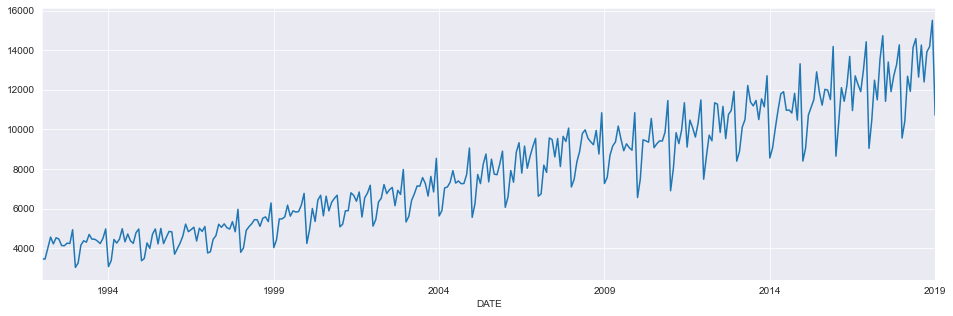

In [17]:
    sales = pd.read_csv("./input/Alcohol_Sales.csv", index_col=0,
                        parse_dates=True)
    sales.plot(figsize=(16, 5), grid=True, legend=False)

In [18]:
X = sales.index
Y = sales['S4248SM144NCEN'].values.astype(float)

test_size = 12
train_set = Y[:-test_size]
test_set = Y[-test_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
train_norm = train_norm.flatten()
train_norm = torch.FloatTensor(train_norm)
window_size = 12
train_data = get_windows(train_norm, window_size)
model = LSTM().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

start = time.time()
epochs=100
for i in range(epochs):
    for X_train, Y_train in train_data:
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                        torch.zeros(1, 1, model.hidden_size).cuda())
        Y_pred = model(X_train)
        loss = criterion(Y_pred, Y_train)
        loss.backward()
        optimizer.step()
    print(f"Epoch : {i + 1} LOSS : {loss.item():.7f}")
end = time.time()
dur = end - start
print(f"Duration : {int(dur / 60)} minutes and {int(dur % 60)} seconds")


Epoch : 1 LOSS : 0.3424794
Epoch : 2 LOSS : 0.2924014
Epoch : 3 LOSS : 0.3491057
Epoch : 4 LOSS : 0.3796735
Epoch : 5 LOSS : 0.3198854
Epoch : 6 LOSS : 0.3291296
Epoch : 7 LOSS : 0.3242176
Epoch : 8 LOSS : 0.3260872
Epoch : 9 LOSS : 0.3251680
Epoch : 10 LOSS : 0.2958480
Epoch : 11 LOSS : 0.3185629
Epoch : 12 LOSS : 0.2597777
Epoch : 13 LOSS : 0.3039959
Epoch : 14 LOSS : 0.2879158
Epoch : 15 LOSS : 0.2938667
Epoch : 16 LOSS : 0.2429449
Epoch : 17 LOSS : 0.2642119
Epoch : 18 LOSS : 0.2742268
Epoch : 19 LOSS : 0.1983271
Epoch : 20 LOSS : 0.1111460
Epoch : 21 LOSS : 0.0103734
Epoch : 22 LOSS : 0.0023233
Epoch : 23 LOSS : 0.0870528
Epoch : 24 LOSS : 0.0024288
Epoch : 25 LOSS : 0.0006031
Epoch : 26 LOSS : 0.0001223
Epoch : 27 LOSS : 0.0011765
Epoch : 28 LOSS : 0.0000001
Epoch : 29 LOSS : 0.0008523
Epoch : 30 LOSS : 0.0012120
Epoch : 31 LOSS : 0.0025443
Epoch : 32 LOSS : 0.0049772
Epoch : 33 LOSS : 0.0066248
Epoch : 34 LOSS : 0.0067937
Epoch : 35 LOSS : 0.0059257
Epoch : 36 LOSS : 0.0047450
E

In [19]:
future = 12
preds = train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    X_test = torch.FloatTensor(preds[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                        torch.zeros(1, 1, model.hidden_size).cuda())
        preds.append(model(X_test).item())

preds[-window_size:]

[0.16615182161331177,
 0.4725273847579956,
 0.4787222743034363,
 0.7476629018783569,
 0.9303236603736877,
 0.40142500400543213,
 0.6679404377937317,
 0.5489376187324524,
 0.5769866108894348,
 0.7311569452285767,
 1.046289086341858,
 0.0294201597571373]

In [20]:
true_predictions = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))
true_predictions

array([[ 9852.40508053],
       [11644.54893714],
       [11680.78594354],
       [13253.95414454],
       [14322.42825136],
       [11228.63556093],
       [12787.61759087],
       [12091.51060078],
       [12255.5831804 ],
       [13157.40255111],
       [15000.76801056],
       [ 9052.5932245 ]])

In [21]:
sales['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

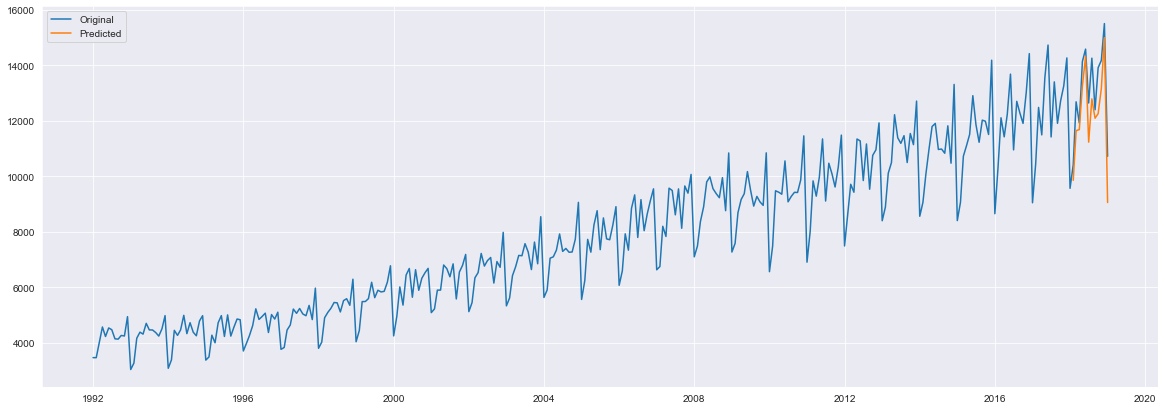

In [22]:
dates = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
dates
plt.figure(figsize=(20,7))
plt.grid(True)
plt.plot(sales['S4248SM144NCEN'],label = 'Original')
plt.plot(dates,true_predictions,label = 'Predicted')
plt.legend()
plt.show()

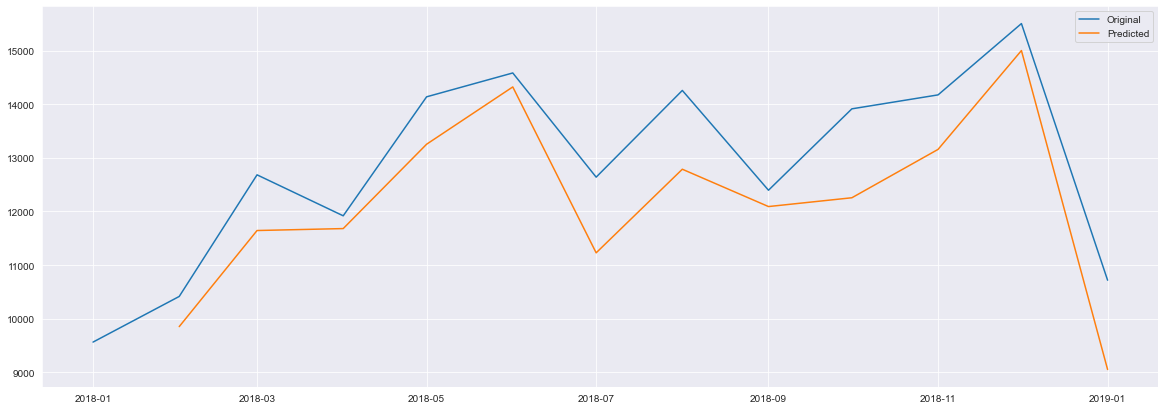

In [23]:
plt.figure(figsize=(20,7))
plt.grid(True)
plt.plot(sales['S4248SM144NCEN']['2018-01-01':],label = "Original")
plt.plot(dates,true_predictions,label = "Predicted")
plt.legend()
plt.show()

In [24]:
Y_norm = scaler.fit_transform(Y.reshape(-1,1))
Y_norm = torch.FloatTensor(Y_norm).view(-1)
full_train_data = get_windows(Y_norm,window_size)

start = time.time()
epochs = 100
model.train()
for i in range(epochs):
    for X_train,Y_train in full_train_data:
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
        Y_pred = model(X_train)
        loss = criterion(Y_pred,Y_train)
        loss.backward()
        optimizer.step()
    print(f"Epoch {i+1} LOSS : {loss.item():.8f}")
end = time.time()
print(f"Train Duration {int((end-start)/60)} minutes {int((end-start)%60)} seconds")

Epoch 1 LOSS : 0.03275571
Epoch 2 LOSS : 0.05228284
Epoch 3 LOSS : 0.03366857
Epoch 4 LOSS : 0.00181468
Epoch 5 LOSS : 0.00260473
Epoch 6 LOSS : 0.01901295
Epoch 7 LOSS : 0.00664340
Epoch 8 LOSS : 0.00645809
Epoch 9 LOSS : 0.00865050
Epoch 10 LOSS : 0.01586642
Epoch 11 LOSS : 0.01744410
Epoch 12 LOSS : 0.02130125
Epoch 13 LOSS : 0.01608079
Epoch 14 LOSS : 0.02752708
Epoch 15 LOSS : 0.01097352
Epoch 16 LOSS : 0.03191399
Epoch 17 LOSS : 0.03172869
Epoch 18 LOSS : 0.01160638
Epoch 19 LOSS : 0.04685212
Epoch 20 LOSS : 0.00784680
Epoch 21 LOSS : 0.01100748
Epoch 22 LOSS : 0.00344607
Epoch 23 LOSS : 0.01278201
Epoch 24 LOSS : 0.02447328
Epoch 25 LOSS : 0.00021977
Epoch 26 LOSS : 0.00994923
Epoch 27 LOSS : 0.06109580
Epoch 28 LOSS : 0.00395298
Epoch 29 LOSS : 0.01873115
Epoch 30 LOSS : 0.05114007
Epoch 31 LOSS : 0.00365170
Epoch 32 LOSS : 0.01778307
Epoch 33 LOSS : 0.02516197
Epoch 34 LOSS : 0.02457238
Epoch 35 LOSS : 0.02763751
Epoch 36 LOSS : 0.07335677
Epoch 37 LOSS : 0.01346707
Epoch 38 L

In [25]:
model.eval()
preds = Y_norm[-window_size:].tolist()
for i in range(future):
    X_test = torch.FloatTensor(preds[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                      torch.zeros(1,1,model.hidden_size).cuda())
        preds.append(model(X_test).item())
preds[-window_size:]
true_predictions = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))
true_predictions
true_predictions = true_predictions.flatten()
dates = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')
dates


array(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
       '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01'],
      dtype='datetime64[D]')

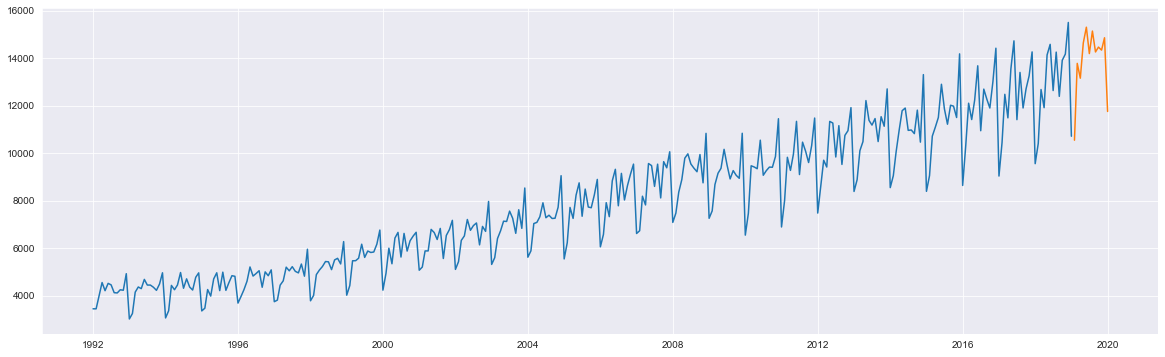

In [26]:
plt.figure(figsize=(20,6))
plt.grid(True)
plt.plot(sales['S4248SM144NCEN'])
plt.plot(dates,true_predictions)
plt.show()

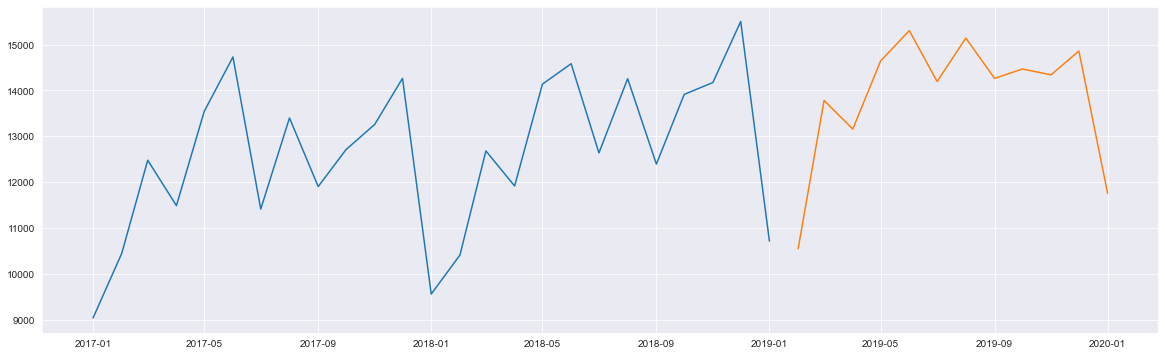

In [27]:
plt.figure(figsize=(20,6))
plt.grid(True)
plt.plot(sales['S4248SM144NCEN']['2017-01-01':])
plt.plot(dates,true_predictions)
plt.show()